In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## ID3 Algorithm

The **ID3 (Iterative Dichotomiser 3)** algorithm is one of the earliest decision tree algorithms, primarily designed for **nominal (unordered) attributes**. It builds the tree by selecting the attribute that provides the highest **information gain** at each node.

- **Binning**: For continuous variables, ID3 bins real-valued attributes into intervals, treating them as discrete nominal attributes.
- **Splits and Branching Factor**: For each chosen attribute, ID3 selects a split that divides the data into **discrete bins**, and the branching factor $ B_j $ is the number of distinct bins for the attribute.
- **Stopping Criterion**: The tree-building process continues until the nodes become pure (i.e., all data points in a node belong to the same class), or there are no more attributes to split on. There is no built-in pruning in ID3.
- **Impurity Measure**: Typically, **entropy** is used to measure the impurity of a node, and the best split is chosen based on maximizing information gain.

### Information Gain Formula:

$$
\text{Information Gain} = \text{Entropy}(S) - \sum_{v \in \text{Values}(A)} \frac{|S_v|}{|S|} \text{Entropy}(S_v)
$$

Where:
- $ S $ is the set of training samples,
- $ A $ is the attribute under consideration,
- $ S_v $ is the subset of samples where attribute $ A $ takes the value $ v $,
- $ \text{Entropy}(S) = - \sum_{i} p_i \log_2(p_i) $ is the entropy of the set $ S $.

## C4.5 Algorithm

**C4.5** is an extension of ID3 and one of the most popular decision tree algorithms. It builds on ID3 with some improvements:

- **Real-Valued Attributes**: C4.5 handles continuous features similarly to **CART** (Classification and Regression Trees) by selecting split points that divide the data based on real-valued attributes.
- **Multi-Way Splits**: Unlike ID3, which splits data into two branches (binary splits), C4.5 allows for **multi-way splits**. For nominal attributes, the branching factor $ B > 2 $.
- **Gain Ratio**: C4.5 uses the **gain ratio** impurity measure, which normalizes the information gain by the intrinsic information of the split to avoid bias towards attributes with many values:

$$
\text{Gain Ratio} = \frac{\text{Information Gain}}{\text{Intrinsic Information}}
$$

Where:

$$
\text{Intrinsic Information} = - \sum_{v \in \text{Values}(A)} \frac{|S_v|}{|S|} \log_2 \left( \frac{|S_v|}{|S|} \right)
$$

- **Pruning**: C4.5 applies a form of **post-pruning**. It uses statistical tests to prune branches that do not improve the accuracy of the tree.
- **Handling Missing Data**: If a feature value is missing for a given instance, C4.5 does not use surrogate splits like CART. Instead, it computes the **probabilities** of each possible answer and follows all possible branches, combining the results weighted by their probabilities.

### C4.5 and CART Comparison

A key difference between **C4.5** and **CART** (Classification and Regression Trees) is how they handle **missing data**:
- **CART**: Uses **surrogate splits** (precomputed alternate splits) for missing values. It tries to predict missing values based on the available data.
- **C4.5**: Does not use surrogate splits. Instead, it follows all possible branches for missing data and assigns a **probabilistic** outcome.

Additionally, **C4.5** tends to be **more space-efficient** than **CART**, as it doesn't store surrogate splits.

## Pruning and Rule Extraction

- **C4.5 Rule Extraction**: After building the tree, **C4.5Rules** simplifies the decision rules derived from the tree. It removes **redundant antecedents** from the rules, optimizing the final set of classification rules.
  
For example, a rule in its original form:

$$
\text{IF} (0.40x_1 + 0.16x_2 < 0.11) \text{ AND } (0.27x_1 - 0.44x_2 < -0.02) \text{ AND } (0.96x_1 - 1.77x_2 < -0.45) \text{ THEN } x \in \omega_1
$$

Could be simplified to:

$$
\text{IF} (0.40x_1 + 0.16x_2 < 0.11) \text{ AND } (5.43x_1 - 13.33x_2 < -6.03) \text{ THEN } x \in \omega_1
$$

This simplification removes unnecessary conditions, making the rules more interpretable.

## Choosing the Best Tree Algorithm

When selecting a decision tree algorithm, various factors need to be considered:

- **Feature Preprocessing**: For nominal features, ID3 and C4.5 are good choices. For continuous features, C4.5 or CART is more suitable.
- **Noise Sensitivity**: Decision trees like **ID3** and **C4.5** are quite robust, but they may overfit if not pruned.
- **Storage and Complexity**: C4.5 may be preferred over CART if space complexity is a major concern because it does not need to store surrogate splits.
- **Pruning**: Pruning is generally preferred over stopping tree growth early. However, pruning large trees can be computationally expensive, so **cross-validation** can be used to find the optimal tree depth and size.

## Conclusion

No single decision tree algorithm universally outperforms the others. The choice of algorithm (ID3, C4.5, or CART) depends on the specific dataset and the trade-offs between performance, complexity, and storage requirements. In practice, **C4.5** is often chosen due to its robustness, ability to handle both nominal and continuous attributes, and built-in pruning and rule simplification capabilities.


In [ ]:
import numpy as np
import pandas as pd

# Function to calculate entropy
def entropy(y):
    class_labels = np.unique(y)
    entropy_val = 0
    for label in class_labels:
        p = np.sum(y == label) / len(y)
        entropy_val -= p * np.log2(p)
    return entropy_val

# Function to calculate information gain
def information_gain(X, y, feature):
    # Calculate entropy before split
    initial_entropy = entropy(y)
    
    # Split data based on feature values
    unique_values = np.unique(X[:, feature])
    weighted_entropy = 0
    for value in unique_values:
        subset_y = y[X[:, feature] == value]
        weighted_entropy += (len(subset_y) / len(y)) * entropy(subset_y)
    
    # Information gain is the difference
    return initial_entropy - weighted_entropy

# Function to choose the best feature to split on
def best_split(X, y):
    best_gain = -1
    best_feature = -1
    for feature in range(X.shape[1]):
        gain = information_gain(X, y, feature)
        if gain > best_gain:
            best_gain = gain
            best_feature = feature
    return best_feature

# Function to build the ID3 decision tree recursively
def id3(X, y, features):
    # If all labels are the same, return the class label
    if len(np.unique(y)) == 1:
        return np.unique(y)[0]
    
    # If no features left to split on, return the most frequent label
    if len(features) == 0:
        return np.argmax(np.bincount(y))
    
    # Find the best feature to split on
    best_feature = best_split(X, y)
    tree = {features[best_feature]: {}}
    
    # Recurse on the subsets of data based on the best feature
    unique_values = np.unique(X[:, best_feature])
    for value in unique_values:
        subset_mask = (X[:, best_feature] == value)
        subset_X = X[subset_mask]
        subset_y = y[subset_mask]
        subset_features = [f for i, f in enumerate(features) if i != best_feature]
        tree[features[best_feature]][value] = id3(subset_X, subset_y, subset_features)
    
    return tree

# Example of how to use the ID3 algorithm
if __name__ == "__main__":
    # Example dataset (X: features, y: labels)
    X = np.array([
        [1, 1],
        [1, 0],
        [0, 1],
        [0, 0],
        [1, 1],
        [1, 0],
        [0, 1],
        [0, 0]
    ])
    
    y = np.array([1, 0, 1, 0, 1, 0, 1, 0])
    
    # Features
    features = ['Feature 1', 'Feature 2']
    
    # Build the decision tree
    tree = id3(X, y, features)
    print("Decision Tree:\n", tree)
import graphviz

# Function to visualize the tree
def visualize_tree(tree):
    dot = graphviz.Digraph()

    def add_nodes_edges(tree, parent_name=None):
        for feature, branches in tree.items():
            feature_name = feature
            node_name = str(id(branches))
            dot.node(node_name, feature_name)
            if parent_name:
                dot.edge(parent_name, node_name)
            if isinstance(branches, dict):
                for value, subtree in branches.items():
                    add_nodes_edges(subtree, parent_name=node_name)

    add_nodes_edges(tree)
    return dot

# Visualize the tree
tree = id3(X, y, features)
dot = visualize_tree(tree)
dot.render('decision_tree', format='png', cleanup=True)


In [ ]:
import graphviz

# Function to visualize the tree
def visualize_tree(tree):
    dot = graphviz.Digraph()

    def add_nodes_edges(tree, parent_name=None):
        if isinstance(tree, dict):  # Internal node with splits
            for feature, branches in tree.items():
                feature_name = feature
                node_name = str(id(branches))
                dot.node(node_name, feature_name)
                if parent_name:
                    dot.edge(parent_name, node_name)
                if isinstance(branches, dict):
                    for value, subtree in branches.items():
                        add_nodes_edges(subtree, parent_name=node_name)
        else:  # Leaf node with class label
            node_name = str(id(tree))
            dot.node(node_name, str(tree))  # Use class label as the node label
            if parent_name:
                dot.edge(parent_name, node_name)

    add_nodes_edges(tree)
    return dot

# Example of how to use the visualize_tree function with the tree from ID3
dot = visualize_tree(tree)
dot.render('decision_tree', format='png', cleanup=True)


# String Matching Algorithms

The task of string matching is fundamental in string processing and pattern recognition problems. In string matching, we are given a **pattern** (candidate string `x`) and a **text** (the larger string), and we need to determine whether the pattern exists within the text, and if so, where it occurs.

## Basic Concepts

### Substring (Factor):
A **substring** (or **factor**) of a string is any contiguous segment of that string. For example, if `x = "GCT"` and `text = "AGCTTC"`, then `"GCT"` is a substring (factor) of `"AGCTTC"`.

### Shift:
A **shift** `s` represents the offset needed to align the first character of the pattern `x` with the `s+1`-th character in the text. The goal of the string matching problem is to find all valid shifts `s` for which the pattern `x` matches a substring in the text.

### Problem Overview:
- **Basic String Matching**: Test if `x` is a factor of `text` and if so, find the positions where `x` occurs in `text`.
- **String Matching with Errors**: Find all locations in `text` where the "cost" or "distance" of `x` to any factor of `text` is minimal.
- **String Matching with "Don't Care" Symbol**: This variant allows a special symbol (often denoted as `*` or `/`) that can match any other symbol.

### Example Problem:
Consider the following example where `x = "bdac"` is the pattern and the text is:


We want to find all valid shifts `s` such that the pattern `x` is a substring of `text`.

### Naive String Matching Algorithm:
The simplest method to solve the string matching problem is the **Naive String Matching Algorithm**. The idea is to check all possible positions in the text where the pattern `x` might start and compare the characters in the pattern to the characters in the text.

#### Naive Algorithm Pseudo-code:
```plaintext
Algorithm 1: Naive String Matching

1. Initialize A, x, text, n ← length[text], m ← length[x]
2. Set s ← 0
3. While s ≤ n - m
   4. If x[1...m] == text[s+1...s+m]
      5. Print "Pattern occurs at shift" s
   6. s ← s + 1
7. Return


Algorithm 2: Boyer-Moore String Matching

1. Initialize A, x, text, n ← length[text], m ← length[x]
2. F(x) ← last-occurrence function
3. G(x) ← good-suffix function
4. Set s ← 0
5. While s ≤ n - m
   6. j ← m
   7. While j > 0 and x[j] == text[s + j]
      8. j ← j - 1
   9. If j == 0
      10. Print "Pattern occurs at shift" s
      11. s ← s + G(0)
   12. Else
      13. s ← s + max(G(j), j - F(text[s + j]))
14. Return


In [7]:
def naive_string_matching(text, pattern):
    n = len(text)
    m = len(pattern)
    
    for s in range(n - m + 1):  # Loop through all possible shifts
        if text[s:s + m] == pattern:  # Check if the substring matches
            print(f"Pattern occurs at shift {s}")

# Example usage:
text = "abacdbdacbbacdac"
pattern = "bdac"
naive_string_matching(text, pattern)


Pattern occurs at shift 5


In [9]:
def last_occurrence(pattern):
    # Create a dictionary to store the last occurrence of each character in the pattern
    last = {}
    for i in range(len(pattern)):
        last[pattern[i]] = i
    return last

def good_suffix(pattern):
    # Create the good-suffix array, this implementation is simplified and assumes no mismatch cases
    m = len(pattern)
    g = [m] * m
    f = [0] * m
    j = m - 1

    for i in range(m - 2, -1, -1):
        if pattern[i] == pattern[m - 1]:
            g[i] = i
            j = i
        else:
            f[i] = j
    
    return g, f

def boyer_moore(text, pattern):
    n = len(text)
    m = len(pattern)
    last = last_occurrence(pattern)
    g, f = good_suffix(pattern)
    
    s = 0
    while s <= n - m:
        j = m - 1
        while j >= 0 and pattern[j] == text[s + j]:
            j -= 1
        
        if j == -1:
            print(f"Pattern occurs at shift {s}")
            s += g[0]  # Move by good-suffix value
        else:
            s += max(g[j], j - last.get(text[s + j], -1))  # Apply both heuristics

# Example usage:
text = "abacdbdacbbacdac"
pattern = "bdac"
boyer_moore(text, pattern)


### Boyer-Moore String Matching Algorithm

The **Boyer-Moore Algorithm** efficiently finds all occurrences of a pattern in a text. It utilizes two heuristics: the **Bad-Character Heuristic** and the **Good-Suffix Heuristic**.

#### Bad-Character Heuristic

The **Bad-Character Heuristic** suggests shifting the pattern based on the mismatch character in the text. For a mismatch at position $ j $ in the pattern, the pattern is shifted to align the last occurrence of the mismatched character in the pattern with the character at the mismatch position in the text.

#### Good-Suffix Heuristic

The **Good-Suffix Heuristic** uses the longest matching suffix of the pattern to decide how to shift the pattern. It ensures no valid shifts are missed by aligning the longest suffix from the pattern with its next occurrence in the text.

Given these two heuristics, the Boyer-Moore algorithm selects the larger shift suggested by the two heuristics and proceeds to the next comparison.

The shift computation using these heuristics involves precomputing the **last occurrence** function and **good-suffix** function:

- **Last Occurrence**: This function records the last occurrence of each character in the pattern.
- **Good Suffix**: This function identifies the largest suffix in the pattern and finds its other occurrences.

---

The algorithm proceeds as follows:
1. If a mismatch occurs, apply the bad-character heuristic.
2. If a good suffix is found, apply the good-suffix heuristic.
3. Shift the pattern by the maximum value suggested by both heuristics.

By combining these heuristics, the Boyer-Moore algorithm can skip large portions of the text, making it faster than the naive string matching algorithm.

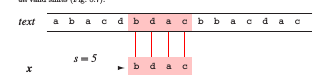

Fig.7: The general string-matching problem is to ﬁnd all shifts s for which the pattern x appears in text. Any such shift is called valid. In this case x = “bdac” is indeed a factor of text, and s = 5 is the only valid shift.

### Boyer-Moore String Matching Algorithm

The **Boyer-Moore Algorithm** efficiently finds all occurrences of a pattern in a text. It utilizes two heuristics: the **Bad-Character Heuristic** and the **Good-Suffix Heuristic**.

#### Bad-Character Heuristic

The **Bad-Character Heuristic** suggests shifting the pattern based on the mismatch character in the text. For a mismatch at position $ j $ in the pattern, the pattern is shifted to align the last occurrence of the mismatched character in the pattern with the character at the mismatch position in the text.

#### Good-Suffix Heuristic

The **Good-Suffix Heuristic** uses the longest matching suffix of the pattern to decide how to shift the pattern. It ensures no valid shifts are missed by aligning the longest suffix from the pattern with its next occurrence in the text.

Given these two heuristics, the Boyer-Moore algorithm selects the larger shift suggested by the two heuristics and proceeds to the next comparison.

The shift computation using these heuristics involves precomputing the **last occurrence** function and **good-suffix** function:

- **Last Occurrence**: This function records the last occurrence of each character in the pattern.
- **Good Suffix**: This function identifies the largest suffix in the pattern and finds its other occurrences.

---

The algorithm proceeds as follows:
1. If a mismatch occurs, apply the bad-character heuristic.
2. If a good suffix is found, apply the good-suffix heuristic.
3. Shift the pattern by the maximum value suggested by both heuristics.

By combining these heuristics, the Boyer-Moore algorithm can skip large portions of the text, making it faster than the naive string matching algorithm.


### Edit Distance Algorithm

The **Edit Distance** algorithm calculates the minimum number of operations required to convert one string into another. The basic operations are:

- **Substitution**: Replace one character in the string with another.
- **Insertion**: Insert a character into the string.
- **Deletion**: Delete a character from the string.

The **Edit Distance** is computed using dynamic programming and is stored in a matrix $ C $, where each entry $ C[i, j] $ represents the minimum edit distance between the substrings $ x[0...i-1] $ and $ y[0...j-1] $.

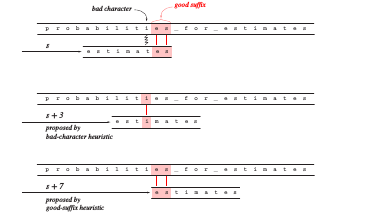

#### Algorithm:

1. Initialize the first row and column of the matrix with values representing the number of operations required to convert an empty string to the target string or vice versa.
2. For each position $ C[i, j] $, compute the cost of the operation based on the three possibilities:
    - **Substitute**: $ C[i-1, j-1] + \delta(x[i], y[j]) $, where $ \delta(x[i], y[j]) = 1 $ if characters differ, else $ 0 $.
    - **Insert**: $ C[i, j-1] + 1 $
    - **Delete**: $ C[i-1, j] + 1 $
3. The value at $ C[m, n] $ (bottom-right corner of the matrix) is the minimum edit distance between the two strings.

#### Formula for Edit Distance:

$$
C[i, j] = \min \left( C[i-1, j] + 1, C[i, j-1] + 1, C[i-1, j-1] + \delta(x[i], y[j]) \right)
$$

where $ \delta(x[i], y[j]) = 1 $ if $ x[i] \neq y[j] $, else $ 0 $.

---

For example, converting the string "excused" to "exhausted" can be done with 1 substitution and 2 insertions. The cost matrix $ C $ will look like this:

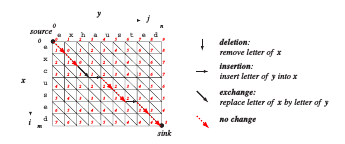

Fig.9: The edit distance calculation for strings x and y can be illustrated in a table. Algorithm 3 begins at source, i = 0, j = 0, and ﬁlls in the cost matrix C, column by column (shown in red), until the full edit distance is placed at the sink, C[i = m, j = n]. The edit distance between “excused” and “exhausted” is thus 3.

$$
\begin{array}{c|cccccccccc}
 & e & x & h & a & u & s & t & e & d \\
\hline
e & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \\
x & 1 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
c & 2 & 1 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
u & 3 & 2 & 2 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
s & 4 & 3 & 3 & 3 & 3 & 4 & 5 & 6 & 7 & 8 \\
e & 5 & 4 & 4 & 4 & 4 & 4 & 5 & 6 & 7 & 8 \\
d & 6 & 5 & 5 & 5 & 5 & 5 & 5 & 6 & 7 & 8 \\
\end{array}
$$

The final edit distance, $ C[7, 9] = 3 $, represents the minimum number of operations required to convert "excused" to "exhausted".



## Boyer-Moore Algorithm:
The Boyer-Moore algorithm is efficient for string matching. It uses two heuristics:

    -Bad-Character Heuristic: It shifts the pattern based on the mismatch character.
    - Good-Suffix Heuristic: It shifts the pattern to align the longest matching suffix with its occurrence.


$$
C[i, j] = \min \left( C[i-1, j] + 1, C[i, j-1] + 1, C[i-1, j-1] + \delta(x[i], y[j]) \right)
$$

where $ \delta(x[i], y[j]) = 1 $ if $ x[i] \neq y[j] $, else $ 0 $.

 Edit Distance Algorithm:
The Edit Distance algorithm calculates the number of insertions, deletions, and substitutions required to convert one string into another. The dynamic programming approach builds a matrix where each cell represents the minimum cost.

$$
C[i, j] = \min \left( C[i-1, j] + 1, C[i, j-1] + 1, C[i-1, j-1] + \delta(x[i], y[j]) \right)
$$


In [11]:
def bad_character_heuristic(pattern):
    """
    Computes the bad character heuristic for the Boyer-Moore algorithm.
    The function returns a dictionary where each character in the pattern 
    maps to the last occurrence of that character.
    """
    bad_char = {}
    m = len(pattern)
    
    # Fill the bad_char dictionary
    for i in range(m):
        bad_char[pattern[i]] = i
    
    return bad_char


def good_suffix_heuristic(pattern):
    """
    Computes the good suffix heuristic for the Boyer-Moore algorithm.
    The function returns a list where each index `i` corresponds to the length 
    of the suffix starting from `i` that matches a suffix of the pattern.
    """
    m = len(pattern)
    g_suffix = [0] * m
    last_prefix = [0] * m
    
    # Find all the prefixes
    last_prefix[m - 1] = m
    j = m - 2
    while j >= 0:
        if pattern[j] == pattern[m - 1 - j]:
            last_prefix[j] = j + 1
        else:
            break
        j -= 1
    
    # Find the good suffix array
    for i in range(m - 1):
        g_suffix[i] = last_prefix[i + 1] if pattern[i] != pattern[m - 1] else m
    return g_suffix


def boyer_moore(text, pattern):
    """
    Boyer-Moore string matching algorithm using both bad character and good suffix heuristics.
    """
    n = len(text)
    m = len(pattern)
    
    if m == 0 or n == 0:
        return []
    
    bad_char = bad_character_heuristic(pattern)
    g_suffix = good_suffix_heuristic(pattern)
    
    s = 0  # Shift of the pattern relative to text
    result = []
    
    while s <= n - m:
        j = m - 1
        
        # Compare pattern with text from right to left
        while j >= 0 and pattern[j] == text[s + j]:
            j -= 1
        
        if j == -1:
            result.append(s)  # Match found at shift `s`
            s += g_suffix[0]
        else:
            # Use the bad character and good suffix heuristics
            bad_shift = bad_char.get(text[s + j], -1)
            good_shift = g_suffix[j]
            
            s += max(good_shift, j - bad_shift)
    
    return result


# Example usage
text = "ababcababcabcabc"
pattern = "abc"
matches = boyer_moore(text, pattern)

print("Pattern found at indices:", matches)


Pattern found at indices: [2, 7, 10, 13]


###  Computational Complexity

Algorithm 3 has a time complexity of **O(mn)**, where `m` is the length of the pattern and `n` is the length of the text. The space complexity is **O(m)** since only the entries in the previous column need to be stored when computing `C[i, j]` for `i = 0 to m`. Due to the importance of string matching and edit distance in computer science, various algorithms have been proposed. Some sophisticated string-matching algorithms can achieve a time complexity of **O(m + n)**.

###  String Matching with Errors

The problem of string matching with errors can be described as follows: Given a pattern `x` and a text, find the shift for which the **edit distance** between `x` and a factor of the text is minimized. The algorithm for string matching with errors is very similar to the one for calculating the edit distance. Let `E` be a matrix of costs, analogous to `C` in Algorithm 3. We seek a shift `s` for which the edit distance to a factor of the text is minimized, formally **min[C(x, y)]** where `y` is any factor of the text.

To compute this, the new cost matrix `E` is defined as:
$$
E[i, j] = \min[C(x[1...i], y[1...j])]
$$

The key difference between the two algorithms (with and without errors) is that in the string matching with errors problem, the initialization of `E[0,j]` is set to 0 (instead of `j` in the basic string matching algorithm). This initialization reflects that the "empty" prefix of `x` matches an empty factor of the text, contributing no cost.

#### Example:
- **Character Mismatch**: `h` → `e` (edit distance = 1)
- **Shift**: `s = 11`

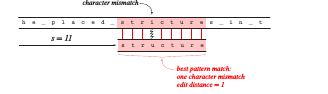

Fig.10: The string matching with errors problem is to ﬁnd the shift s for which the edit distance between x and an aligned factor of text is minimum. In this illustration, the minimum edit distance is 1, corresponding to the character exchange u → i and the shift s = 11 is the location.
###  String Matching with the "Don’t-Care" Symbol

String matching with the "don't-care" symbol (denoted `/`) is formally the same as basic string matching, but any occurrence of `/` in either the pattern `x` or the text matches any character. For example, consider the following illustration where `/` matches any character in the text or pattern:

**Text**: `"r c h _ p a / t e r / s _ i n _ l o n g / s t r / n g s"`  
**Pattern**: `"x p a t t / r / s"`

The matching rule is that the `/` symbol matches any character.

#### Example:
The valid shift is the one where the pattern with `/` matches a factor of the text, as shown in the figure.

### String Matching with Errors: Practical Considerations

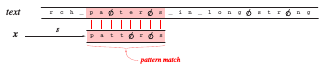

Fig.11: String matching with don’t care symbol is the same as basic string matching except the / symbol — in either text or x — matches any character. The ﬁgure shows the only valid shift.

1. **Candidate Lengths**: The lengths of candidate factors of text to be considered are roughly equal to the length of the pattern `x`.
2. **Early Termination**: For each candidate shift, the edit distance calculation can be terminated early if the current cost already exceeds the minimum edit distance.

In practice, these heuristics can significantly reduce computational burden.

### Grammatical Methods in Pattern Recognition

So far, we have not addressed the underlying models used to generate strings. Now, we turn to cases where the structure of the string is critical. This structure is often hierarchical, with abstract, simple representations at the top level and more complex representations at subsequent levels.

For example, the string `"The history book clearly describes several wars"` can be broken down into the following levels:
1. **Sentence Level**: "The history book clearly describes several wars"
2. **Noun Phrase + Verb Phrase**: At a more detailed level, it can be described as a noun phrase followed by a verb phrase.

Grammatical methods can improve the accuracy of recognition systems by enforcing structural constraints. For instance, in Optical Character Recognition (OCR) systems for mathematical equations, a grammar might define valid slots for upper and lower limits of an integral sign. Similarly, for recognizing telephone numbers, a grammar can limit possible patterns based on international and national phone numbering conventions.

In summary, a grammar can improve pattern recognition by reducing the space of valid candidates, leading to more accurate results.





In [13]:
import numpy as np

# Function to compute the edit distance (Levenshtein distance) between two strings
def edit_distance(x, y):
    m = len(x)
    n = len(y)
    # Create a matrix for dynamic programming
    C = np.zeros((m + 1, n + 1), dtype=int)
    
    # Initialize the first row and first column
    for i in range(m + 1):
        C[i][0] = i
    for j in range(n + 1):
        C[0][j] = j
    
    # Fill in the rest of the matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if x[i - 1] == y[j - 1] else 1
            C[i][j] = min(
                C[i - 1][j] + 1,       # Deletion
                C[i][j - 1] + 1,       # Insertion
                C[i - 1][j - 1] + cost # Substitution
            )
    
    # Return the edit distance
    return C[m][n]

# Function for string matching with errors
def string_matching_with_errors(pattern, text):
    m = len(pattern)
    n = len(text)
    min_edit_distance = float('inf')
    best_shift = -1
    
    # Loop through all possible shifts (alignments of pattern to text)
    for s in range(n - m + 1):
        substring = text[s:s + m]
        # Compute the edit distance for this alignment
        distance = edit_distance(pattern, substring)
        
        # Track the minimum edit distance and the corresponding shift
        if distance < min_edit_distance:
            min_edit_distance = distance
            best_shift = s
            
    return best_shift, min_edit_distance

# Function to compute the edit distance with the "don't care" symbol
def edit_distance_with_dont_care(x, y, dont_care_symbol="/"):
    m = len(x)
    n = len(y)
    C = np.zeros((m + 1, n + 1), dtype=int)
    
    # Initialize the first row and column
    for i in range(m + 1):
        C[i][0] = i
    for j in range(n + 1):
        C[0][j] = j
    
    # Fill the matrix with edit distance values
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if x[i - 1] == y[j - 1] or x[i - 1] == dont_care_symbol or y[j - 1] == dont_care_symbol:
                cost = 0
            else:
                cost = 1
            C[i][j] = min(
                C[i - 1][j] + 1,       # Deletion
                C[i][j - 1] + 1,       # Insertion
                C[i - 1][j - 1] + cost # Substitution
            )
    
    return C[m][n]
    
# Function for string matching with the "don't care" symbol
def string_matching_with_dont_care(pattern, text, dont_care_symbol="/"):
    m = len(pattern)
    n = len(text)
    min_edit_distance = float('inf')
    best_shift = -1
    
    for s in range(n - m + 1):
        substring = text[s:s + m]
        # Compute the edit distance considering the don't care symbol
        distance = edit_distance_with_dont_care(pattern, substring, dont_care_symbol)
        
        if distance < min_edit_distance:
            min_edit_distance = distance
            best_shift = s
            
    return best_shift, min_edit_distance

# Example usage
if __name__ == "__main__":
    # Example pattern and text
    pattern = "str/r"
    text = "r c h _ p a / t e r / s _ i n _ l o n g / s t r / n g s"

    # Using string matching with errors
    best_shift, min_distance = string_matching_with_errors(pattern, text)
    print(f"Best shift: {best_shift}, Minimum edit distance: {min_distance}")

    # Using string matching with don't care symbol
    best_shift_dont_care, min_distance_dont_care = string_matching_with_dont_care(pattern, text)
    print(f"Best shift with don't care symbol: {best_shift_dont_care}, Minimum edit distance: {min_distance_dont_care}")


Best shift: 42, Minimum edit distance: 3
Best shift with don't care symbol: 42, Minimum edit distance: 3


###  Grammatical Methods

Up to here, we have not been concerned with any detailed models that might underlie the generation of the sequence of characters in a string. We now turn to the case where rules of a particular sort were used to generate the strings and thus where their structure is fundamental. Often this structure is hierarchical, where at the highest or most abstract level a sequence is very simple, but at subsequent levels there is greater and greater complexity. For instance, at its most abstract level, the string “The history book clearly describes several wars” is merely a sentence. At a somewhat more detailed level it can be described as a noun phrase followed by a verb phrase. The noun phrase can be expanded at yet a subsequent level, as can the verb phrase. The expansion ends when we reach the words “The,” “history,” and so forth — items that are considered the “characters,” atomic and without further structure.

Consider too strings representing valid telephone numbers — local, national, and international. Such numbers conform to a strict structure: either a country code is present or it is not; if not, then the domestic national code may or may not be present; if a country code is present, then there is a set of permissible city codes, and for each city, there is a set of permissible area codes and individual local numbers, and so on. As we shall see, such structure is easily specified in a grammar, and when such structure is present, the use of a grammar for recognition can improve accuracy.

For instance, grammatical methods can be used to provide constraints for a full system that uses a statistical recognizer as a component. Consider an optical character recognition system that recognizes and interprets mathematical equations based on a scanned pixel image. The mathematical symbols often have specific “slots” that can be filled with certain other symbols; this can be specified by a grammar. Thus an integral sign has two slots, for upper and lower limits, and these can be filled by only a limited set of symbols. (Indeed, a grammar is used in many mathematical typesetting programs in order to prevent authors from creating meaningless “equations.”) A full system that recognizes the integral sign could use a grammar to limit the number of candidate categories for a particular slot, and this increases the accuracy of the full system.

Similarly, consider the problem of recognizing phone numbers within acoustic speech in an automatic dialing application. A statistical or Hidden-Markov-Model acoustic recognizer might perform word spotting and pick out number words such as “eight” and “hundred.” A subsequent stage based on a formal grammar would then exploit the fact that telephone numbers are highly constrained, as mentioned.

We shall study the case when crisp rules specify how the representation at one level leads to a more expanded and complicated representation at the next level. We sometimes call a string generated by a set of rules a sentence; the rules are specified by a grammar, denoted $ G $. (Naturally, there is no requirement that these be related in any way to sentences in natural language such as English.) In pattern recognition, we are given a sentence and a grammar, and seek to determine whether the sentence was generated by $G $.

###  Grammars

The notion of a grammar is very general and powerful. Formally, a grammar $ G $ consists of four components:

1. **Symbols**: Every sentence consists of a string of characters (which are also called primitive symbols, terminal symbols, or letters), taken from an alphabet $ A $. For bookkeeping, it is also convenient to include the null or empty string denoted $ \epsilon $, which has length zero; if $ \epsilon $ is appended to any string $ x $, the result is again $ x $.

2. **Variables**: These are also called non-terminal symbols, intermediate symbols, or occasionally internal symbols, and are taken from a set $ I $.

3. **Root Symbol**: The root symbol or starting symbol is a special internal symbol, the source from which all sequences are derived. The root symbol is taken from a set $ S $.

4. **Production Rules**: The set of production rules, rewrite rules, or simply rules, denoted $ P $, specify how to transform a set of variables and symbols into other variables and symbols. These rules determine the core structures that can be produced by the grammar.

For instance, if $ A $ is an internal symbol and $ c $ a terminal symbol, the rewrite rule $ cA \rightarrow cc $ means that any time the segment $ cA $ appears in a string, it can be replaced by $ cc $. Thus we denote a general grammar by its alphabet, its variables, its particular root symbol, and the rewrite rules: 
$$
G = (A, I, S, P)
$$
The language generated by grammar $ G $, denoted $ L(G) $, is the set of all strings (possibly infinite in number) that can be generated by $ G $.

Consider two examples; the first is quite simple and abstract. Let $ A = \{a, b, c\} $,
$$
P = \{ p_1: S \rightarrow aSBA \, \text{or} \, aBA, p_2: AB \rightarrow BA, p_3: bB \rightarrow bb, p_4: bA \rightarrow bc, p_5: cA \rightarrow cc, p_6: aB \rightarrow ab \}
$$
We can derive strings from the grammar as follows:

1. Start with $ S $ and apply the rewrite rules in these sequences:
   $$
   \text{root} \, S \rightarrow aBA \rightarrow abA \rightarrow aBABA \rightarrow abc \rightarrow aabbcc
   $$
   These derivations show that "abc" and "aabbcc" are in the language generated by $ G $.

In fact, it can be shown (Problem 38) that this grammar generates the language $ L(G) = \{a^n b^n c^n | n \geq 1 \} $.

A much more complicated grammar underlies the English language, of course. The alphabet consists of all English words, $ A = \{\text{the}, \text{history}, \text{book}, \text{sold}, \text{over}, \text{1000}, \text{copies}, \dots \} $, and the intermediate symbols are the parts of speech: 
$$
I = \{\text{noun}, \text{verb}, \text{noun phrase}, \text{verb phrase}, \text{adjective}, \text{adverb}, \text{adverbial phrase}\}
$$
The root symbol here is $ S = \text{sentence} $. A restricted set of the production rules in English includes:
$$
\begin{aligned}
\text{sentence} & \rightarrow \text{noun phrase} \, \text{verb phrase} \\
\text{noun phrase} & \rightarrow \text{adjective} \, \text{noun phrase} \\
\text{verb phrase} & \rightarrow \text{verb} \, \text{adverbial phrase} \\
\text{noun} & \rightarrow \text{book} \, \text{or} \, \text{theorem} \\
\text{verb} & \rightarrow \text{describes} \, \text{or} \, \text{buys} \\
\text{adjective} & \rightarrow \text{history} \\
\end{aligned}
$$
This subset of the rules of English grammar does not prevent the generation of meaningless sentences, of course. For instance, the nonsense sentence “Squishy green dreams hop heuristically” can be derived in this subset of English grammar.

Figure 8.12 shows the steps of a production in a derivation tree, where the root symbol derivation is displayed at the top and the terminal symbols at the bottom.

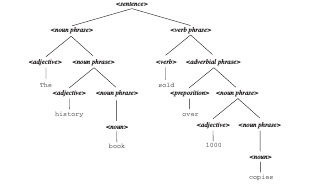

Fig.12: This derivation tree illustrates how a portion of English grammar can transform the root symbol, here sentence, into a particular sentence or string of elements, here English words, which are read from left to right.

In [14]:
import random

class CFG:
    def __init__(self, grammar):
        """
        Initialize the grammar with the provided production rules.
        :param grammar: A dictionary where the keys are non-terminal symbols and the values are lists of production rules.
        """
        self.grammar = grammar

    def generate(self, symbol):
        """
        Recursively generate a string from the start symbol.
        :param symbol: The current symbol (starting from the root symbol).
        :return: A string representing the sentence derived from the grammar.
        """
        if symbol not in self.grammar:
            # If it's a terminal (no production rules), return the symbol itself
            return symbol
        # Choose a random production rule for the symbol
        production = random.choice(self.grammar[symbol])
        # Recursively generate strings for the symbols in the production
        return " ".join(self.generate(s) for s in production)


# Example Grammar Definition
grammar = {
    'sentence': [['noun_phrase', 'verb_phrase']],
    'noun_phrase': [['adjective', 'noun'], ['noun']],
    'verb_phrase': [['verb', 'noun_phrase'], ['verb']],
    'adjective': [['history'], ['sold'], ['big']],
    'noun': [['book'], ['theorem'], ['copy']],
    'verb': [['describes'], ['holds'], ['buys']],
}

# Initialize the grammar
cfg = CFG(grammar)

# Generate a sentence starting from the root symbol 'sentence'
generated_sentence = cfg.generate('sentence')

print("Generated Sentence:", generated_sentence)


Generated Sentence: history copy describes book


## Types of String Grammars

In this section, we discuss the four main types of grammars based on different types of structure in the production rules.

### Type 0: Free or Unrestricted Grammar
Free grammars have no restrictions on the rewrite rules and thus they provide no constraints or structure on the strings they can produce. While in principle they can express an arbitrary set of rules, this generality comes at the tremendous expense of possibly unbounded learning time. Knowing that a string is derived from a type 0 grammar provides no information and as such, type 0 grammars generally have little use in pattern recognition.

### Type 1: Context-Sensitive Grammar
A grammar is called context-sensitive if every rewrite rule is of the form:

$$
\alpha I \beta \rightarrow \alpha x \beta
$$

Where:
- $ \alpha $ and $ \beta $ are any strings made up of intermediate and terminal symbols,
- $ I $ is an intermediate symbol,
- $ x $ is an intermediate or terminal symbol (other than the empty string $ \epsilon $).

We say that "I can be rewritten as x in the context of $ \alpha $ on the left and $ \beta $ on the right."

## Type 2: Context-Free Grammar
A grammar is called context-free if every production is of the form:

$$
I \rightarrow x
$$

Where:
- $ I $ is an intermediate symbol,
- $ x $ is an intermediate or terminal symbol (other than the empty string $ \epsilon $).

Clearly, unlike a type 1 grammar, here there is no need for a "context" for the rewriting of $ I $ by $ x $.

## Type 3: Finite State or Regular Grammar
A grammar is called regular if every rewrite rule is of the form:

$$
\alpha \rightarrow z\beta \quad \text{or} \quad \alpha \rightarrow z
$$

Where:
- $ \alpha $ and $ \beta $ are made up of intermediate symbols,
- $ z $ is a terminal symbol (other than the empty string $ \epsilon $).

Such grammars are also called finite state because they can be generated by a finite state machine.

## Hierarchy of Grammars
A language generated by a grammar of type $ i $ is called a type $ i $ language. It can be shown that the class of grammars of type $ i $ includes all grammars of type $ i + 1 $; thus, there is a strict hierarchy in grammars.

### Chomsky Normal Form (CNF)
Any context-free grammar can be converted into one in **Chomsky Normal Form (CNF)**. A grammar in CNF has all rules of the form:

$$
A \rightarrow BC \quad \text{or} \quad A \rightarrow z
$$

Where $ A $, $ B $, and $ C $ are intermediate symbols, and $ z $ is a terminal symbol. For every context-free grammar $ G $, there is another grammar $ G' $ in CNF such that $ L(G) = L(G') $.

## Example: A Grammar for Pronouncing Numbers
Consider a grammar that yields the pronunciation of any number between 1 and 999,999. The alphabet has 29 basic terminal symbols, i.e., the spoken words:

$$
A = \{ \text{one}, \text{two}, \dots, \text{ten}, \text{eleven}, \dots, \text{twenty}, \dots, \text{ninety}, \text{hundred}, \text{thousand} \}
$$

There are six non-terminal symbols corresponding to general six-digit, three-digit, and two-digit numbers, the numbers between ten and nineteen, and so forth:

$$
I = \{ \text{digits6}, \text{digits3}, \text{digits2}, \text{digit1}, \text{teens}, \text{tys} \}
$$

The root node corresponds to a general number up to six digits in length:

$$
S = \text{digits6}
$$

The set of rewrite rules is based on the knowledge of English:

$$
\begin{aligned}
\text{digits6} &\rightarrow \text{digits3 thousand digits3} \\
\text{digits6} &\rightarrow \text{digits3 thousand} \mid \text{digits3} \\
\text{digits3} &\rightarrow \text{digit1 hundred digits2} \\
\text{digits3} &\rightarrow \text{digit1 hundred} \mid \text{digits2} \\
\text{digits2} &\rightarrow \text{teens} \mid \text{tys} \mid \text{tys digit1} \mid \text{digit1} \\
\text{digit1} &\rightarrow \text{one} \mid \text{two} \mid \dots \mid \text{nine} \\
\text{teens} &\rightarrow \text{ten} \mid \text{eleven} \mid \dots \mid \text{nineteen} \\
\text{tys} &\rightarrow \text{twenty} \mid \text{thirty} \mid \dots \mid \text{ninety}
\end{aligned}
$$

### Example Derivations
The grammar takes `digits6` and applies the productions until the elements in the final alphabet are produced. For example:

1. **639,014**:
   - $\text{digits6} \rightarrow \text{digits3 thousand digits3}$
   - $\text{digits3} \rightarrow \text{digit1 hundred digits2}$
   - $\text{digit1} \rightarrow \text{six}$
   - $\text{digits2} \rightarrow \text{tys digit1}$
   - $\text{digit1} \rightarrow \text{three}$
   - Result: "six hundred thirty nine thousand fourteen"

2. **2,953**:
   - $\text{digits6} \rightarrow \text{digits3 thousand}$
   - $\text{digits3} \rightarrow \text{digit1 hundred digits2}$
   - $\text{digit1} \rightarrow \text{two}$
   - $\text{digits2} \rightarrow \text{tys digit1}$
   - $\text{digit1} \rightarrow \text{nine}$
   - Result: "two thousand nine hundred fifty three"


In [15]:
class NumberToWords:
    def __init__(self):
        # Define the terminal symbols for digits, teens, tens, and large number scales
        self.ones = ["", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen"]
        self.tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]
        self.scales = ["", "thousand", "million"]

    def number_to_words(self, num):
        if num == 0:
            return "zero"
        words = self.convert(num)
        return ' '.join(words).strip()

    def convert(self, num):
        if num == 0:
            return []
        elif num < 20:
            return [self.ones[num]]
        elif num < 100:
            return [self.tens[num // 10]] + self.convert(num % 10)
        elif num < 1000:
            return [self.ones[num // 100]] + ["hundred"] + self.convert(num % 100)
        else:
            for idx, scale in enumerate(self.scales[1:], 1):
                if num < 1000 ** (idx + 1):
                    return self.convert(num // 1000**idx) + [scale] + self.convert(num % 1000**idx)

# Example usage:
number_to_words = NumberToWords()

# Convert numbers to words
print(number_to_words.number_to_words(639014))  # Output: "six hundred thirty nine thousand fourteen"
print(number_to_words.number_to_words(2953))    # Output: "two thousand nine hundred fifty three"


six hundred thirty nine thousand fourteen
two thousand nine hundred fifty three


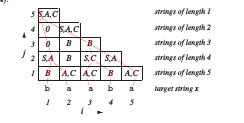

Fig.13: The bottom-up parsing algorithm ﬁlls the parse table with symbols that might be part of a valid derivation. The pink lines are not provided by the algorithm, but when read downward from the root symbol conﬁrm that a valid derivation exists.

##  Recognition Using Grammars

Recognition using grammars is formally very similar to the general approaches used throughout pattern recognition. Suppose we suspect that a test sentence was generated by one of $ c $ different grammars, $ G_1, G_2, \dots, G_c $, which can be considered as different models or classes. A test sentence $ x $ is classified according to which grammar could have produced it, or equivalently, the language $ L(G_i) $ of which $ x $ is a member.

Up to now, we have worked forward — forming a derivation from a root node to a final sentence. For recognition, though, we must employ the inverse process: that is, given a particular $ x $, find a derivation in $ G $ that leads to $ x $. This process, called **parsing**, is virtually always much more difficult than forming a derivation.

### Bottom-up Parsing

Bottom-up parsing starts with the test sentence $ x $, and seeks to simplify it, so as to represent it as the root symbol. The basic approach is to use candidate productions from $ P $ “backwards,” i.e., find rewrite rules whose right-hand side matches part of the current string, and replace that part with a segment that could have produced it. This is the general method in the **Cocke-Younger-Kasami (CYK)** algorithm, which fills a parse table from the “bottom up.”

The grammar must be expressed in **Chomsky normal form** and thus the productions $ P $ must all be of the form:
$$
A \rightarrow BC
$$
where $ A, B, C $ are intermediate symbols, and $ A $ is the root symbol.

## Algorithm : Bottom-up Parsing

The following is the Bottom-up Parsing Algorithm, represented in pseudo-code:
$$
\text{1. begin initialize } G = (A, I, S, P), x = x_1 x_2 \dots x_n $$
$$
\text{2. } i \gets 0
$$
$$
\text{3. do } i \gets i + 1
$$
$$
\text{4. } V_{i1} \gets \{ A \mid A \to x_i \}
$$
$$
\text{5. until } i = n
$$
$$
\text{6. } j \gets 1
$$
$$
\text{7. do } j \gets j + 1
$$
$$
\text{8. } i \gets 0
$$
$$
\text{9. do } i \gets i + 1
$$
$$
\text{10. } V_{ij} \gets \emptyset
$$
$$
\text{11. } k \gets 0
$$
$$
\text{12. do } k \gets k + 1
$$
$$
\text{13. } V_{ij} \gets V_{ij} \cup \{ A \mid A \to BC \in P, B \in V_{ik} \text{ and } C \in V_{i+k,j-k} \}
$$
$$
\text{14. until } k = j - 1
$$
$$
\text{15. until } i = n - j + 1
$$
$$
\text{16. until } j = n
$$
$$
\text{17. if } S \in V_{1n} \text{ then print "parse of } x \text{ successful in } G
$$
$$
\text{18. return}
$$
$$
\text{19. end}
$$


### Explanation

- **Step 1-5**: Initialize the grammar and the input string. Fill the table with the terminal symbols corresponding to each character in the input string.
  
- **Step 6-16**: Iteratively fill the parse table by checking for pairs of symbols that could combine to form a higher-level non-terminal symbol.

- **Step 17**: If the root symbol $ S $ appears in the top-right cell $ V_{1n} $ of the table, then the parsing of string $ x $ is successful in grammar $ G $.

### Time and Space Complexity

The **time complexity** of this algorithm is $ O(n^3) $, where $ n $ is the length of the input string. Similarly, the **space complexity** is $ O(n^3) $ due to the parse table's size.


### Algorithm 4: Bottom-up Parsing

The following is a simplified version of Algorithm 4 for bottom-up parsing:


### Example Grammar

Consider a grammar $G $ with the following rules:

$$
\begin{aligned}
    S &\rightarrow AB \mid BC \\
    A &\rightarrow BA \mid a \\
    B &\rightarrow CC \mid b \\
    C &\rightarrow AB \mid a
\end{aligned}
$$

The string $ x = \text{"baaba"} $ can be parsed using the algorithm by filling the parse table, where each cell represents a subproblem that can be solved by applying the grammar rules.

### Parse Table

The parse table for the string "baaba" is filled as follows:

$$
\begin{array}{c|c c c c c}
    & b & a & a & b & a \\
    \hline
    1 & B & A,C & A & A,C & B \\
    2 & S,A & B & B & A & A,C \\
    3 & B & A,C & C & S,A & S,A \\
    4 & A & B & C & B & B \\
\end{array}
$$

- **Row 1**: The first row (j=1) contains the non-terminal symbols that generate each individual terminal symbol.
- **Row 2**: Subsequent rows (j > 1) consider combinations of segments of the string, building possible derivations from smaller to larger segments.

If the root symbol $ S $ appears in the top-right cell, the parsing is successful.

### Time and Space Complexity

- **Time complexity**: The innermost loop (line 13) is executed $ O(n^3) $, where $ n $ is the length of the string.
- **Space complexity**: The space complexity is also $ O(n^3) $ due to the size of the parse table.

### Top-down Parsing and Other Methods

Top-down parsing starts with the root node and applies the productions successively, with the goal of matching the test sentence. While top-down parsing is simpler in concept, it often suffers from inefficiencies, such as unnecessary computations. There are other parsing methods which are based on finite state machines (FSMs), where the grammar is modeled as states and transitions.

### Conclusion

Bottom-up parsing is a powerful technique that can handle a wide variety of grammars, but its time complexity makes it less suitable for real-time applications. Other parsing methods, such as top-down parsing and finite state machine parsing, offer alternative trade-offs between efficiency and expressiveness.


## Bottom-Up Parsing Algorithm

In this section, we describe the core computation of the bottom-up parsing algorithm. The algorithm works by filling a parse table with symbols that could form parts of valid derivations. The process proceeds from the bottom to the top, filling in cells with intermediate symbols derived from other symbols. 

## Parse Table Filling

The core computation of the algorithm happens in line 13, where entries in the table are filled with symbols that can contribute to segments in lower rows and potentially form part of a valid derivation.

For example:
- The cell at $ i = 1, j = 2 $ contains symbols that could produce segments in the row beneath it. Specifically, this entry contains $ S $ because of the rule $ p1: S \rightarrow BC $, and it also contains $ A $ because of the rule $ p2: A \rightarrow BA $.
- The innermost loop (lines 12-14) iterates over $ k $, which checks for left-hand sides of rules that span a range.

### Example for $ i = 3, j = 3 $:
- The entry at $ i = 3, j = 3 $ contains $ B $ because, for $ k = 2 $, the rule \( p3: B \rightarrow CC \) applies (as shown in Fig. 8.14).

### Table Structure

Consider the following table, where symbols are filled progressively:
- **Strings of length 1**: $ S, A, C $
- **Strings of length 2**: $ S, A, C $
- **Strings of length 3**: $ B $
- **Strings of length 4**: $ S, A $
- **Strings of length 5**: $ A, C $

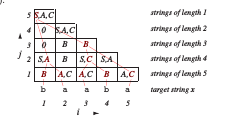

Fig.13: The bottom-up parsing algorithm ﬁlls the parse table with symbols that might be part of a valid derivation. The pink lines are not provided by the algorithm, but when read downward from the root symbol conﬁrm that a valid derivation exists.

This is shown in Fig.13.

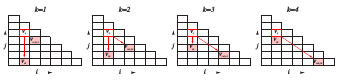

Fig.14: The innermost loop of Algorithm 4 seeks to ﬁll a cell $V_(ij)$ (outlined in red) by the left-hand side of any rewrite rule whose right-hand side corresponds to symbols in the two shaded cells. As k is incremented, the cells queried move vertically upward to the cell in question, and diagonally down from that cell. The shaded cells show the possible right-hand sides in a derivation, as illustrated by the pink lines in Fig. 8.13.


## Fig.14: Filling a Cell

In Fig.14, the process of filling a particular cell  $V_{ij} $ is illustrated. The sequence sweeps vertically up to the cell in question, while diagonally down from the cell in question. This ensures that all paths leading to a valid derivation are found. If the top cell contains the root symbol $ S $ (and potentially other symbols), it confirms that the string has been successfully parsed.

For instance:
- The cell at $ j = 1, i = 4 $ contains $ B $ because of the rule $ p3: B \rightarrow CC $.
- The remaining cells for $ j = 1 $ contain $ A $ and $ C $ because these are the only symbols that can derive $ a $.

## Time and Space Complexity

- **Time Complexity**: $ O(n^3) $, where $ n $ is the length of the input string.
- **Space Complexity**: $ O(n^2) $, as the parse table has $ n^2 $ cells.

## Top-Down Parsing

Top-down parsing operates by starting with the root node $ S $ and applying rewrite rules to attempt to derive the input string $ x $. The key challenge in top-down parsing is choosing which rewrite rule to apply at each step.

### Parsing Strategy

- The parse begins at the first character of the string.
- A set of rules is applied to derive the first character.
- Subsequent characters are derived by iterating through the productions.

## Fig.15: Valid Derivation

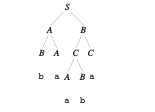

Fig.15: This valid derivation of “babaa” in G can be read from the pink lines in the parse table of Fig.13 generated by the bottom-up parse algorithm.

The valid derivation of the string "babaa" in the grammar $ G $ is shown in Fig.15. The derivation can be read from the pink lines in the parse table of Fig.13, which was generated by the bottom-up parse algorithm.

### LaTeX Code for Equations

The bottom-up parsing can be mathematically expressed using the following notation:

- For any symbol $ X $, the rule $ X \rightarrow YZ $ means that symbol $ X $ can be replaced by the concatenation of $ Y $ and $ Z $.
  
In the parse table, for any $ V_{ij} $, the value is filled by the left-hand side of a rule whose right-hand side matches the symbols in the two shaded cells:
$$
V_{ij} = \{ X \mid X \rightarrow YZ, \text{ where } Y \in V_{i,k} \text{ and } Z \in V_{k+1,j} \}
$$
This equation ensures that the cell $ V_{ij} $ is filled with all possible non-terminal symbols $ X $ that can generate a substring of the target string.



In [16]:
class BottomUpParser:
    def __init__(self, grammar, target_string):
        # Grammar is a dictionary of production rules
        # Grammar is in the form of {'A': [('B', 'C'), ('D',)]} for rules like A -> BC and A -> D
        self.grammar = grammar
        self.target_string = target_string
        self.n = len(target_string)
        self.table = [[set() for _ in range(self.n)] for _ in range(self.n)]
    
    def parse(self):
        # Fill the table for substrings of length 1
        for i in range(self.n):
            symbol = self.target_string[i]
            for lhs, rhs_list in self.grammar.items():
                for rhs in rhs_list:
                    if len(rhs) == 1 and rhs[0] == symbol:
                        self.table[i][i].add(lhs)
        
        # Fill the table for substrings of length 2 or more
        for length in range(2, self.n + 1):  # length is the length of the substring
            for i in range(self.n - length + 1):
                j = i + length - 1  # j is the end index of the substring
                for k in range(i, j):  # k is the partition point
                    # Check all possible split points (i..k) and (k+1..j)
                    for lhs, rhs_list in self.grammar.items():
                        for rhs in rhs_list:
                            if len(rhs) == 2:
                                left, right = rhs
                                if left in self.table[i][k] and right in self.table[k + 1][j]:
                                    self.table[i][j].add(lhs)
        
        # Check if the root symbol S is in the top-right cell of the table
        if 'S' in self.table[0][self.n - 1]:
            print("The string can be derived!")
        else:
            print("The string cannot be derived.")

# Example grammar and target string
grammar = {
    'S': [('B', 'C'), ('A', 'B')],
    'A': [('B', 'A')],
    'B': [('a',)],
    'C': [('b',)],
}

target_string = "babaa"

# Initialize the parser and parse the string
parser = BottomUpParser(grammar, target_string)
parser.parse()


The string cannot be derived.


In [17]:
class BottomUpParser:
    def __init__(self, grammar, target_string):
        """
        Initialize the BottomUpParser with a grammar and target string.
        
        :param grammar: Dictionary of production rules where keys are non-terminal symbols
                        and values are lists of tuples representing production right-hand sides.
        :param target_string: The string to be parsed.
        """
        self.grammar = grammar
        self.target_string = target_string
        self.n = len(target_string)
        # Initialize a parse table with empty sets for each cell.
        self.table = [[set() for _ in range(self.n)] for _ in range(self.n)]

    def parse(self):
        """
        Parse the target string using the bottom-up parsing algorithm.
        """
        # Fill the table for substrings of length 1 (base case)
        for i in range(self.n):
            symbol = self.target_string[i]
            for lhs, rhs_list in self.grammar.items():
                for rhs in rhs_list:
                    if len(rhs) == 1 and rhs[0] == symbol:
                        self.table[i][i].add(lhs)

        # Fill the table for substrings of length 2 or more
        for length in range(2, self.n + 1):  # length of substring
            for i in range(self.n - length + 1):
                j = i + length - 1  # j is the end index of the substring
                for k in range(i, j):  # k is the partition point
                    # Check all production rules that could span the partition
                    for lhs, rhs_list in self.grammar.items():
                        for rhs in rhs_list:
                            if len(rhs) == 2:  # Only consider binary rules (X -> YZ)
                                left, right = rhs
                                if left in self.table[i][k] and right in self.table[k + 1][j]:
                                    self.table[i][j].add(lhs)

        # The root symbol is 'S'. Check if 'S' is in the top-right cell of the table
        if 'S' in self.table[0][self.n - 1]:
            print("The string can be derived!")
        else:
            print("The string cannot be derived.")

# Example grammar and target string
grammar = {
    'S': [('B', 'C'), ('A', 'B')],  # S -> BC | AB
    'A': [('B', 'A')],              # A -> BA
    'B': [('a',)],                   # B -> a
    'C': [('b',)],                   # C -> b
}

target_string = "babaa"

# Initialize the parser and parse the string
parser = BottomUpParser(grammar, target_string)
parser.parse()


The string cannot be derived.


In [18]:
class BottomUpParser:
    def __init__(self, grammar, target_string):
        """
        Initialize the BottomUpParser with a grammar and target string.
        
        :param grammar: Dictionary of production rules where keys are non-terminal symbols
                        and values are lists of tuples representing production right-hand sides.
        :param target_string: The string to be parsed.
        """
        self.grammar = grammar
        self.target_string = target_string
        self.n = len(target_string)
        # Initialize a parse table with empty sets for each cell.
        self.table = [[set() for _ in range(self.n)] for _ in range(self.n)]

    def parse(self):
        """
        Parse the target string using the bottom-up parsing algorithm.
        """
        # Fill the table for substrings of length 1 (base case)
        for i in range(self.n):
            symbol = self.target_string[i]
            for lhs, rhs_list in self.grammar.items():
                for rhs in rhs_list:
                    if len(rhs) == 1 and rhs[0] == symbol:
                        self.table[i][i].add(lhs)

        # Fill the table for substrings of length 2 or more
        for length in range(2, self.n + 1):  # length of substring
            for i in range(self.n - length + 1):
                j = i + length - 1  # j is the end index of the substring
                for k in range(i, j):  # k is the partition point
                    # Check all production rules that could span the partition
                    for lhs, rhs_list in self.grammar.items():
                        for rhs in rhs_list:
                            if len(rhs) == 2:  # Only consider binary rules (X -> YZ)
                                left, right = rhs
                                if left in self.table[i][k] and right in self.table[k + 1][j]:
                                    self.table[i][j].add(lhs)

        # The root symbol is 'S'. Check if 'S' is in the top-right cell of the table
        if 'S' in self.table[0][self.n - 1]:
            print("The string can be derived!")
        else:
            print("The string cannot be derived.")

# Example grammar and target string
grammar = {
    'S': [('A', 'B')],  # S -> AB
    'A': [('a',)],      # A -> a
    'B': [('b',)],      # B -> b
}

target_string = "abab"

# Initialize the parser and parse the string
parser = BottomUpParser(grammar, target_string)
parser.parse()


The string cannot be derived.


## Grammatical Inference Overview

Grammatical inference aims to learn a grammar from a set of positive and negative example sentences. The goal is to produce the simplest grammar that generates all positive examples and no negative ones.

## Algorithm 5: Grammatical Inference (Overview)

Below is the high-level description of the grammatical inference algorithm:

$$
\begin{array}{l}
\textbf{Input:} \quad D^+ \text{ (positive examples)}, \, D^- \text{ (negative examples)}, \, G_0 \text{ (initial grammar)} \\
\textbf{Output:} \quad G = (A, I, S, P) \text{ (final grammar)} \\
\\
\text{Initialize } D^+, D^-, G_0 \\
n^+ \leftarrow |D^+| \text{ (number of positive examples)} \\
S \leftarrow \text{start symbol} \\
A \leftarrow \text{set of terminal symbols in } D^+ \\
i \leftarrow 0 \\
\\
\text{while not all positive examples are processed:} \\
\quad i \leftarrow i + 1 \\
\quad \text{Read } x^+_i \text{ from } D^+ \\
\quad \text{if } x^+_i \text{ cannot be parsed by } G_0: \\
\quad \quad \text{Propose additional production rules to } P \text{ and variables to } I \\
\quad \quad \text{Accept updates if grammar parses } x^+_i \text{ and does not parse any string from } D^- \\
\\
\text{End while} \\
\\
\text{Eliminate redundant productions} \\
\text{Return } G = \{A, I, S, P\}
\end{array}
$$

### Key Steps in the Algorithm:

1. **Initialize Grammar**: The process begins by initializing the set of positive examples $ D^+ $, negative examples $ D^- $, and the initial grammar $ G_0 $.

2. **Iterate Over Positive Examples**: For each positive example $ x^+_i $, check if it can be parsed by the current grammar. If not, propose new production rules and update the grammar.

3. **Update the Grammar**: After each positive example, ensure the grammar parses the sentence correctly and does not parse any negative examples.

4. **Final Grammar**: After processing all positive examples, the final grammar is returned. Redundant rules are eliminated.

### Example: FSM Grammar for Sentence Generation

Consider a finite state machine (FSM) grammar for sentences. A type 3 grammar (regular grammar) might consist of production rules like:

$$
\begin{aligned}
S &\rightarrow \text{the} A \\
A &\rightarrow \text{mouse} B \mid \text{cow} B \\
B &\rightarrow \text{found} C \\
C &\rightarrow \epsilon \\
\end{aligned}
$$

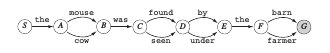

Fig.16: One type of ﬁnite state machine consists of nodes that can emit terminal symbols (“the,” “mouse,” etc.) and transition to another node. Such operation can be described by a grammar. For instance, the rewrite rules for this ﬁnite state machine include S → theA, A → mouseB OR cowB, and so on. Clearly these rules imply this ﬁnite state machine implements a type 3 grammar. The ﬁnal internal node (shaded) would lead to the null symbol ).

This grammar generates sentences like "the mouse found", "the cow found", etc., and could be refined via grammatical inference to match observed data.

### Grammatical Inference in Practice


In [20]:
import random

# Initial Grammar (very simple for the purpose of the example)
class Grammar:
    def __init__(self):
        # Initialize with basic start symbol and no rules
        self.rules = {}
        self.start_symbol = 'S'
        
    def add_rule(self, lhs, rhs):
        if lhs not in self.rules:
            self.rules[lhs] = []
        self.rules[lhs].append(rhs)
    
    def parse(self, sentence):
        # For simplicity, this function will attempt to parse a sentence using the rules.
        # This can be extended with a parser logic (e.g., CYK parsing or recursive descent)
        return self._parse_helper(self.start_symbol, sentence, 0)

    def _parse_helper(self, lhs, sentence, index):
        # A simple recursive descent approach to check if we can parse the sentence
        if index == len(sentence) and lhs == '':
            return True
        if lhs not in self.rules:
            return False
        for rhs in self.rules[lhs]:
            if isinstance(rhs, str):  # Terminal symbol
                if rhs == sentence[index:index+len(rhs)]:
                    return True
            else:  # Non-terminal symbol
                for symbol in rhs:
                    if not self._parse_helper(symbol, sentence, index):
                        return False
        return False

# Grammatical Inference Algorithm
class GrammaticalInference:
    def __init__(self, positive_examples, negative_examples):
        self.D_plus = positive_examples
        self.D_minus = negative_examples
        self.grammar = Grammar()

    def infer_grammar(self):
        i = 0
        n_plus = len(self.D_plus)
        
        # Add initial grammar rules
        self.grammar.add_rule('S', ['A'])
        self.grammar.add_rule('A', ['a', 'b'])  # Example terminals for simplicity

        # Iterate through positive examples
        while i < n_plus:
            x_plus_i = self.D_plus[i]
            print(f"Processing example: {x_plus_i}")
            if not self.grammar.parse(x_plus_i):
                self.propose_new_rules(x_plus_i, i)  # Pass 'i' as argument
                if self.is_valid_grammar():
                    i += 1
                else:
                    print(f"Invalid grammar. Reverting changes for: {x_plus_i}")
                    self.revert_changes()
        
        # Return final grammar after processing all positive examples
        print("Final Grammar:", self.grammar.rules)
        return self.grammar

    def propose_new_rules(self, x_plus_i, i):
        # Propose new rules based on the positive example x_plus_i
        # This is a very simplistic approach for the demonstration.
        new_rule = f"X{i}"  # Create a new variable based on the example index
        self.grammar.add_rule(new_rule, [x_plus_i])
        print(f"Proposed new rule: {new_rule} -> {x_plus_i}")

    def is_valid_grammar(self):
        # Check if the current grammar parses all negative examples
        for x_minus in self.D_minus:
            if self.grammar.parse(x_minus):
                print(f"Grammar incorrectly parses negative example: {x_minus}")
                return False
        return True

    def revert_changes(self):
        # Revert the last change (simplified for the example)
        self.grammar.rules = {k: v for k, v in list(self.grammar.rules.items())[:-1]}

# Example positive and negative examples
positive_examples = ['ab', 'aa', 'ba']
negative_examples = ['a', 'b', 'abb']

# Create an instance of the GrammaticalInference class
inference = GrammaticalInference(positive_examples, negative_examples)

# Infer the grammar
inferred_grammar = inference.infer_grammar()


Processing example: ab
Proposed new rule: X0 -> ab
Processing example: aa
Proposed new rule: X1 -> aa
Processing example: ba
Proposed new rule: X2 -> ba
Final Grammar: {'S': [['A']], 'A': [['a', 'b']], 'X0': [['ab']], 'X1': [['aa']], 'X2': [['ba']]}


## Grammar Inference Example

In this example, we will infer a grammar $ G $ from the given positive and negative examples using the grammatical inference algorithm described. The positive examples are denoted by $ D^+ $, and the negative examples by $ D^- $.

### Given:
- **Positive examples**: $ D^+ = \{a, aaa, aaab, aab\} $
- **Negative examples**: $ D^- = \{ab, abc, abb, aabb\} $
- **Alphabet**: $ A = \{a, b\} $
- **Initial grammar $ G_0 $**: We begin with a single internal symbol, and the simplest rewrite rule: 
  $$
  P = \{ S \to A \}
  $$
  
### Algorithm Progress

| Step | Positive Example $ x_i^+ $ | Current Rules $ P $ | Does the Rule Produce Any $ x_i^- $? |
|------|-----------------------------|-----------------------|-----------------------------------------|
| 1    | $ a $                      | $ S \to A $         | No                                      |
| 2    | $ aaa $                    | $ S \to A, A \to a $ | No                                      |
| 3    | $ aaab $                   | $ S \to A, A \to a $ | Yes: $ ab \in D^- $                  |
| 3    | $ aaab $                   | $ S \to A, A \to a, A \to aA $ | No                                      |
| 4    | $ aab $                    | $ S \to A, A \to a, A \to aA $ | No                                      |

### Explanation of the Process

1. **Step 1**: The first positive example is `a`. This leads to the rule:
   $$
   A \to a
   $$
   This rule does not generate any negative examples from $ D^- $, so it is accepted.

2. **Step 2**: The second positive example is `aaa`. The rule $A \to a$ is already in place, so we propose:
   $$
   A \to aA
   $$
   This does not generate any strings in $ D^- $, so it is accepted.

3. **Step 3**: The third positive example is `aaab`. At this point, we propose the rule $A \to ab$ to match the example. However, this rule generates `ab`, which is part of $ D^- $, so it is rejected. We then propose:
   $$
   A \to aA, A \to aab
   $$
   This rule does not generate any strings in $ D^- $, so it is accepted.

4. **Step 4**: The fourth positive example is `aab`. The rules already in place cover this example, so no new rules are needed.

### Final Inferred Grammar

The final grammar after processing all positive examples is:

$$
\begin{aligned}
S &\to A \\
A &\to a \\
A &\to aA \\
A &\to aab
\end{aligned}
$$

This is the grammar that successfully generates all positive examples without generating any negative examples. This is a basic example of grammatical inference using positive and negative training data.

### Conclusion

This example demonstrates the basic idea behind grammatical inference, where we iteratively adjust the grammar based on the training data. The process is generalized by adding more complex constraints for real-world applications, such as limiting the grammar type (Type 3, Type 2, etc.). For type 3 grammars, finite state machines may be used.


In [21]:
class Grammar:
    def __init__(self):
        self.rules = {}  # Stores the production rules
        self.start_symbol = 'S'

    def add_rule(self, lhs, rhs):
        """ Add a new rule to the grammar """
        if lhs not in self.rules:
            self.rules[lhs] = []
        self.rules[lhs].append(rhs)

    def parse(self, sentence):
        """ Check if a sentence can be parsed with the current grammar """
        return self._parse_helper(self.start_symbol, sentence, 0)

    def _parse_helper(self, lhs, sentence, index):
        """ Helper function to recursively check if a string can be derived from a given non-terminal symbol """
        if index == len(sentence) and lhs == '':
            return True
        if lhs not in self.rules:
            return False
        for rhs in self.rules[lhs]:
            if isinstance(rhs, str):  # Terminal symbol
                if rhs == sentence[index:index+len(rhs)]:
                    return True
            else:  # Non-terminal symbol
                for symbol in rhs:
                    if not self._parse_helper(symbol, sentence, index):
                        return False
        return False

class GrammaticalInference:
    def __init__(self, positive_examples, negative_examples):
        self.D_plus = positive_examples
        self.D_minus = negative_examples
        self.grammar = Grammar()

    def infer_grammar(self):
        i = 0
        n_plus = len(self.D_plus)
        
        # Initial grammar with start symbol S and simple rule
        self.grammar.add_rule('S', ['A'])

        # Process each positive example
        while i < n_plus:
            x_plus_i = self.D_plus[i]
            print(f"Processing positive example: {x_plus_i}")
            
            # If the current grammar cannot parse x_plus_i, propose new rules
            if not self.grammar.parse(x_plus_i):
                self.propose_new_rules(x_plus_i, i)  # Pass 'i' as argument for new rule generation
                if self.is_valid_grammar():  # Ensure no negative example is parsed
                    i += 1  # Accept the new rule
                else:
                    print(f"Invalid grammar after adding rules for {x_plus_i}. Reverting changes.")
                    self.revert_changes()  # Revert the changes if the grammar is invalid
            else:
                i += 1  # Proceed to the next example if the grammar already works

        # Return the inferred grammar
        print("Final Inferred Grammar:")
        for lhs, rhs in self.grammar.rules.items():
            print(f"{lhs} -> {', '.join(map(str, rhs))}")
        return self.grammar

    def propose_new_rules(self, x_plus_i, i):
        """ Propose new rules based on the positive example x_plus_i """
        new_rule = f"X{i}"  # Create a new variable rule
        self.grammar.add_rule('A', [x_plus_i])  # Add a rule to match the positive example
        print(f"Proposed new rule: A -> {x_plus_i}")

    def is_valid_grammar(self):
        """ Ensure the current grammar does not parse any negative example """
        for x_minus in self.D_minus:
            if self.grammar.parse(x_minus):
                print(f"Grammar incorrectly parses negative example: {x_minus}")
                return False
        return True

    def revert_changes(self):
        """ Revert the last rule change (simplified for this case) """
        self.grammar.rules = {k: v for k, v in list(self.grammar.rules.items())[:-1]}

# Example positive and negative examples
positive_examples = ['a', 'aaa', 'aaab', 'aab']
negative_examples = ['ab', 'abc', 'abb', 'aabb']

# Create an instance of the GrammaticalInference class
inference = GrammaticalInference(positive_examples, negative_examples)

# Infer the grammar
inferred_grammar = inference.infer_grammar()


Processing positive example: a
Proposed new rule: A -> a
Processing positive example: aaa
Proposed new rule: A -> aaa
Processing positive example: aaab
Proposed new rule: A -> aaab
Processing positive example: aab
Proposed new rule: A -> aab
Final Inferred Grammar:
S -> ['A']
A -> ['a'], ['aaa'], ['aaab'], ['aab']
